In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   7150      0 --:--:-- --:--:-- --:--:--  7150
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.39)
Already up to date.


In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
mkdir data/mnist/

In [0]:
mv mnist.pkl.gz data/mnist/

In [0]:
path = Path('data/mnist/')

In [0]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

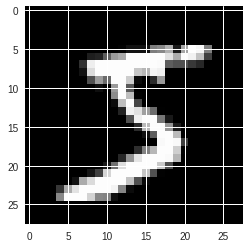

In [0]:
plt.imshow(x_train[0].reshape(28,28), cmap='gray')
x_train.shape

In [0]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max(), x_train.min(), x_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9), tensor(0.), tensor(0.9961))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [0]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784,10, bias=True)
  
  def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 1e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y, lr):
  wd = 1e-5
  y_hat = model(x)
  # weight_decay
  w2 = 0.
  for p in model.parameters(): w2 += (p**2).sum()
  # add to regular loss
  loss = loss_func(y_hat, y) + w2*wd
  
  loss.backward()
  with torch.no_grad():
    for p in model.parameters():
      p.sub_(lr * p.grad)
      p.grad.zero_()
  return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]


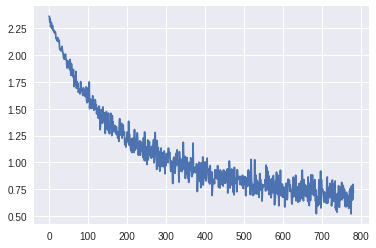

In [0]:
plt.plot(losses)

In [0]:
len(losses)
len(data.train_dl)

781

**Two layer NN with SGD update**

In [0]:
class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 55, bias=True)
    self.lin2 = nn.Linear(55, 10, bias=True)
    
  def forward(self, xb):
    x = self.lin1(xb)
    x = nn.functional.relu(x)
    return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

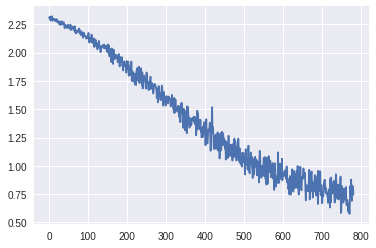

In [0]:
plt.plot(losses)

**Adam without momentum**

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
  opt = optim.Adam(model.parameters(), lr)
  y_hat = model(x)
  loss = loss_func(y_hat, y) # calculate loss
  
  loss.backward() # backprop
  opt.step() # weight update
  opt.zero_grad()
  return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

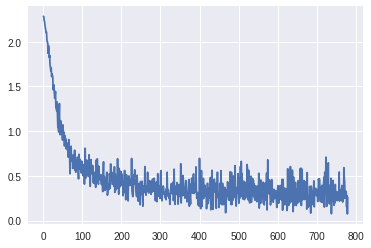

In [0]:
plt.plot(losses)

**SGD with momentum :**

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
  '''
  sgd with momentum
  '''
  opt = optim.SGD(model.parameters(), lr, momentum=0.9)
  y_hat = model(x)
  loss = loss_func(y_hat, y) # calculate loss
  
  loss.backward() # backprop
  opt.step() # weight update
  opt.zero_grad()
  return loss.item()

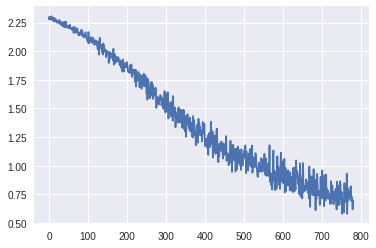

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]
plt.plot(losses)

**Adam with weight decay (=1e-1) :**

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
  '''
  adam with momentum
  '''
  opt = optim.Adam(model.parameters(), lr, weight_decay=1e-1)
  y_hat = model(x)
  loss = loss_func(y_hat, y) # calculate loss
  
  loss.backward() # backprop
  opt.step() # weight update
  opt.zero_grad()
  return loss.item()

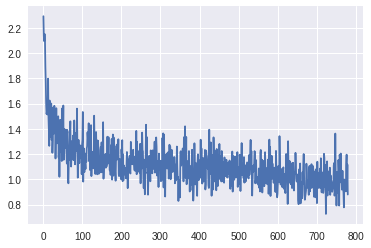

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]
plt.plot(losses)

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


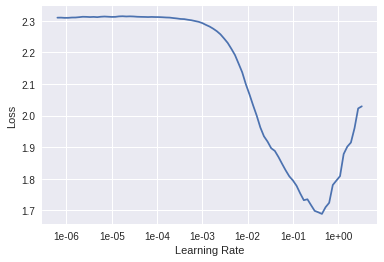

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 8e-3)

epoch,train_loss,valid_loss,accuracy
1,0.147402,0.131961,0.963200


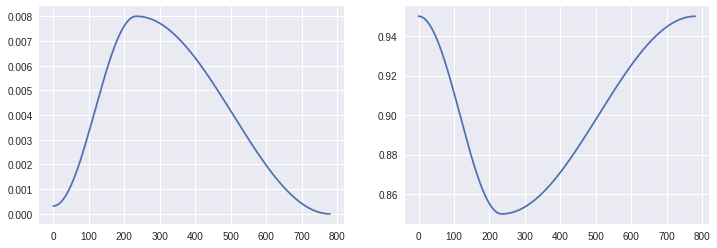

In [0]:
learn.recorder.plot_lr(show_moms=True)

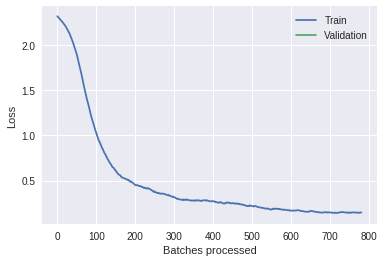

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('mnist-1st')

## fin

In [0]:
learn.load('mnist-1st')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f13808920b8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f1380892780>;

Test: None, model=Mnist_NN(
  (lin1): Linear(in_features=784, out_features=55, bias=True)
  (lin2): Linear(in_features=55, out_features=10, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=CrossEntropyLoss(), metrics=[<function accuracy at 0x7f1381206730>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[<class 'fastai.basic_train.Recorder'>], callbacks=[], layer_groups=[Sequential(
  (0): Linear(in_features=784, out_features=55, bias=True)
  (1): Linear(in_features=55, out_features=10, bias=True)
)])

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


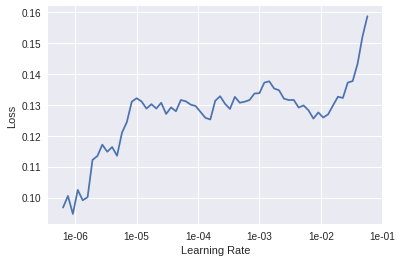

In [0]:
learn.lr_find()
learn.recorder.plot()